# Transfer Learning


In this notebook we are going to investigate Transfer Learning using models available from torchvision.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SharifiZarchi/Introduction_to_Machine_Learning/blob/main/Jupyter_Notebooks/Chapter_04_Computer_Vision/Transfer_Learning.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/SharifiZarchi/Introduction_to_Machine_Learning/main/Jupyter_Notebooks/Chapter_04_Computer_Vision/Transfer_Learning.ipynb)

In [1]:
# @title setup and imports

from matplotlib import pyplot as plt
from tqdm import trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision import transforms, models
from torchvision.datasets.cifar import CIFAR10

from torchsummary import summary

torch.manual_seed(0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
# @title helper functions

def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.
    train_acc = 0.
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        train_acc += (logits.argmax(dim=1) == labels).sum().item()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader.dataset)
    return train_loss, train_acc


def validate_epoch(model, dataloader, loss_fn, device):
    model.eval()
    val_loss = 0.
    val_acc = 0.
    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()
            val_acc += (logits.argmax(dim=1) == labels).sum().item()
        val_loss /= len(dataloader)
        val_acc /= len(dataloader.dataset)
    return val_loss, val_acc


def train_model(model, train_dataloader, val_dataloader, optimizer, n_epochs, device=device):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    loss_fn = CrossEntropyLoss()
    for _ in (pbar := trange(n_epochs)):
        train_loss, train_acc = train_epoch(model, train_dataloader, loss_fn, optimizer, device)
        history['train_loss'].append(train_loss), history['train_acc'].append(train_acc)
        val_loss, val_acc = validate_epoch(model, val_dataloader, loss_fn, device)
        history['val_loss'].append(val_loss), history['val_acc'].append(val_acc)
        pbar.set_description(f'Training Accuracy {100 * train_acc:.2f}% | Validation Accuracy {100 * val_acc:.2f}% ')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history['train_loss'], label='train')
    ax1.plot(history['val_loss'], label='val')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['train_acc'], label='train')
    ax2.plot(history['val_acc'], label='val')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()


def compare_results(normal_results, pre_trained_results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(results['train_acc'], label='Normal')
    ax1.plot(pre_trained_results['train_acc'], label='Pre-Trained')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training Accuracy')
    ax1.legend()

    ax2.plot(results['val_acc'], label='Normal')
    ax2.plot(pre_trained_results['val_acc'], label='Pre-Trained')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Test Accuracy')
    ax2.legend()

    plt.show()

In [3]:
# @title CIFAR10 dataset

norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)
batch_size = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# ResNet18



To observe the improvement caused by transfer learning, we train the `ResNet18` model twice, once with pre-trained weights (from the ImageNet dataset) and once without pre-training.

## Without Pre-Training

We will start by training a ResNet18 without pre-trained weights, so we set `weights=None`.

Training Accuracy 84.10% | Validation Accuracy 81.65% : 100%|██████████| 20/20 [09:41<00:00, 29.06s/it]


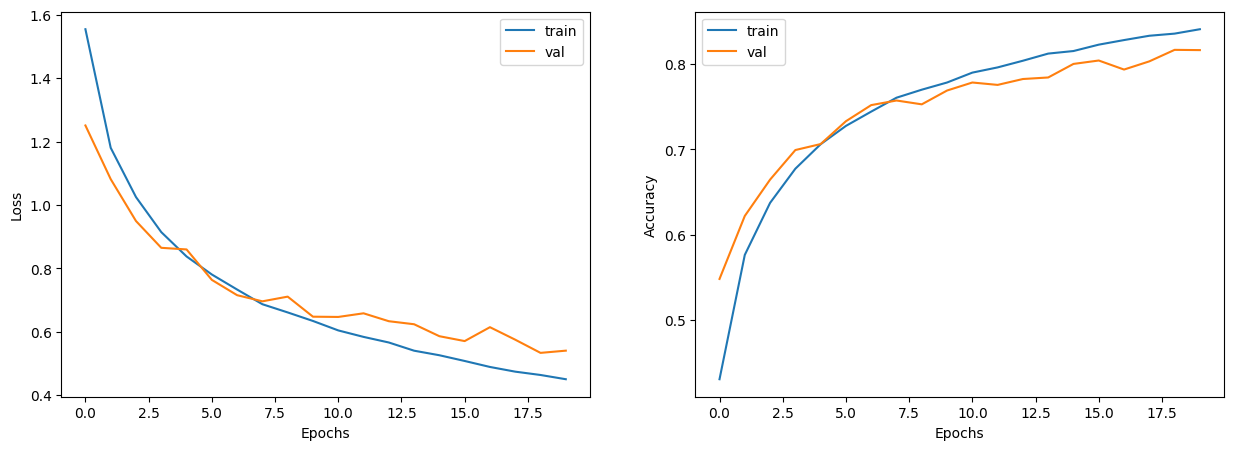

In [4]:
resnet18 = models.resnet18(weights=None)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, len(classes))

resnet18 = resnet18.to(device)
if device == 'cuda':
    resnet18 = torch.compile(resnet18)
optim = Adam(resnet18.parameters())

results = train_model(resnet18, trainloader, testloader, optim, n_epochs=20)
plot_history(results)

## With Pre-Training

By setting `weights='DEFAULT'` we can load the pre-trained weights.

In [5]:
resnet18 = models.resnet18(weights='DEFAULT')
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, len(classes))

resnet18 = resnet18.to(device)
if device == 'cuda':
    resnet18 = torch.compile(resnet18)

We can fine-tune the pre-trained model. Here we are not going to freeze any of its layers and therefore the only real difference from normal trainig is that instead of initializing the network, we use pre-trained weights.

Training Accuracy 86.99% | Validation Accuracy 84.66% : 100%|██████████| 20/20 [09:51<00:00, 29.56s/it]


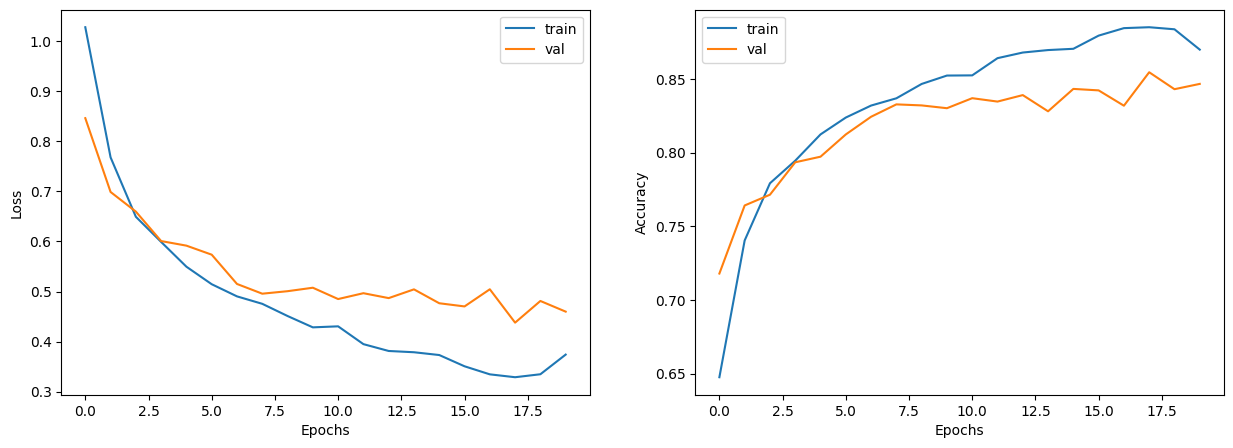

In [6]:
optim = Adam(resnet18.parameters())
pt_results = train_model(resnet18, trainloader, testloader, optim, n_epochs=20)
plot_history(pt_results)

## Results

As you can see the pre-trained weights improve the accuracy significantly.

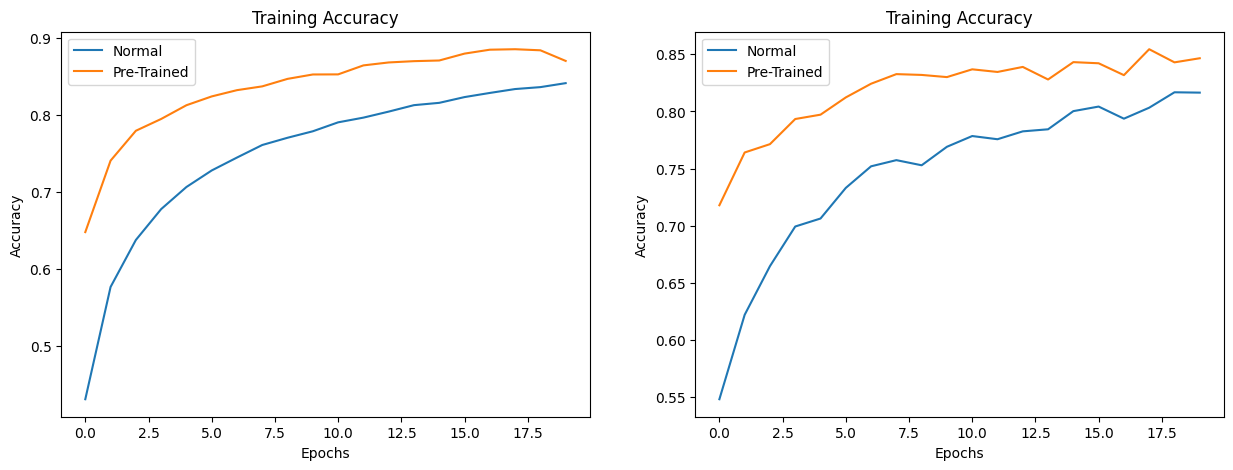

In [7]:
compare_results(results, pt_results)

# ResNet152

Alternatively we could have frozen all the layers except for the final fully connected layer which is what we are going to do here.

In [8]:
resnet152 = models.resnet152(weights='DEFAULT')

# Freeze All Layers Except the Final Fully Connected Layer
for param in resnet152.parameters():
    param.requires_grad = False

# Replace the Final Fully Connected Layer
num_ftrs = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs, len(classes))

resnet152 = resnet152.to(device)
if device == 'cuda':
    resnet152 = torch.compile(resnet152)

All we have to do now is to pass the parameters of the fully connected layer to the optimizer and train the model.

Training Accuracy 38.78% | Validation Accuracy 42.24% : 100%|██████████| 15/15 [10:02<00:00, 40.16s/it]


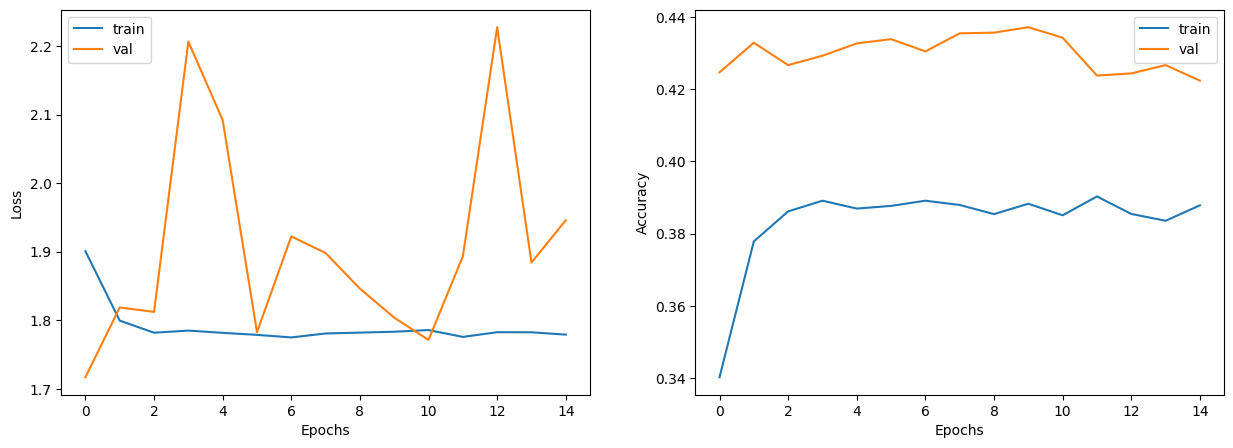

In [9]:
optim = Adam(resnet152.fc.parameters())
results = train_model(resnet152, trainloader, testloader, optim, n_epochs=15)
plot_history(results)

# To Freeze or not to Freeze 🥶


> ⚠️ It's often best **NOT TO FREEZE** the layers. ⚠️

## When to Freeze Layers
- **Small Dataset**: If your dataset is small, freezing most of the layers helps prevent overfitting. The pretrained layers already contain useful features learned from a large dataset.
- **Similar Task**: If your new task is similar to the original task the model was trained on, freezing the layers can help retain the useful features.
- **Limited Computational Resources**: Freezing layers reduces the number of parameters to train, which can save computational resources and time.

## When Not to Freeze Layers
- **Large Dataset**: If you have a large dataset, you can afford to unfreeze more layers to fine-tune the model more extensively.
- **Different Task**: If your new task is significantly different from the original task, you might need to unfreeze more layers to adapt the model to the new task.
- **Performance Needs**: If the initial performance with frozen layers is not satisfactory, you can gradually unfreeze layers and fine-tune them to improve performance.

# Refrences

*   [Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
*   [Models and Pre-Trained Weights from PyTorch](https://pytorch.org/vision/stable/models.html)
